In [1]:
!pip install wget
!pip install python-louvain
import wget
import networkx as nx
import numpy as np
import pprint
from matplotlib import pyplot as plt
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.approximation import clique
from community import community_louvain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=f2fee5f424db73f45c444d31b797e4a1ffff224a6a8065af871f9f4a288f9c73
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
def download_pdb():
  pdbid = (input('PDBID:')).strip()+ '.pdb'
  url = "https://files.rcsb.org/download/" + pdbid
  wget.download(url)
  return pdbid

In [3]:
def read_pdb(file_path = None):
  try:
    pdb_dict = {} # Dictionary of residues as keys and inner dictionaries as values.
    inner_dict = {} # Dictionary of atoms as keys and coordinates as values
    rows = ["   "] # First element is dummy variable will be removed.
    with open(file_path, "r") as file:
        # Pre-process pdb file (Multiple predictions for residues removed, only first prediction stored)
        for line in file:
          row = line.strip().split()
          if row[0] == "ATOM" and row[2] != rows[-1][2] and row[5].isdigit(): # Doesnt catch the negative residues!!!
            rows.append(row)
        rows.remove("   ")
        # Take coordinates into dictionary
        i = 0
        while i < len(rows):
          while rows[i][5] == rows[i+1][5]:
            inner_dict[rows[i][2]] = list(np.array(rows[i][6:9]).astype(float))
            i += 1
            if i+1 >= len(rows):
              inner_dict[rows[i][2]] = list(np.array(rows[i][6:9]).astype(float))
              break
            if rows[i][5] != rows[i+1][5]:
              inner_dict[rows[i][2]] = list(np.array(rows[i][6:9]).astype(float))
          pdb_dict[rows[i][4]+rows[i][5]+rows[i][3][-3:]] = inner_dict.copy()
          inner_dict = {}
          i += 1
  except FileNotFoundError:
    print("File path is NOT correct!")

  return pdb_dict

In [4]:
def calculate_edges(pdb_dict, node_type = "CA", thresholds = (4,7), weighted = False):
  edges = []
  """ Kyte & Doolittle hydrophobicity scale values were normalized by using sigmodi function to obtain hydrophocity values between 0 and 1."""
  Hydrophobicity = {'ALA': 0.8581, 'ARG': 0.0109, 'ASN': 0.0293, 'ASP': 0.0293, 'CYS': 0.9241, 'GLN': 0.0293, 
                    'GLU': 0.0293, 'GLY': 0.4013, 'HIS': 0.0391, 'ILE': 0.9890, 'LEU': 0.9781, 'LYS': 0.0198, 
                    'MET': 0.8698, 'PHE': 0.9426, 'PRO': 0.1679, 'SER': 0.3100, 'THR': 0.3318, 'TRP': 0.2890,
                    'TYR': 0.2141, 'VAL': 0.9852}
  
  if node_type == "CA" or node_type == "N" or node_type == "C" or node_type == "CB":
    for residue,coordinates in pdb_dict.items():
      for residue2,coordinates2 in pdb_dict.items():
        try:
          bond_dist = np.linalg.norm(np.array(coordinates[node_type])-np.array(coordinates2[node_type]))
          
          if bond_dist >= thresholds[0] and bond_dist < thresholds[1]:
            
            if weighted:
              if (Hydrophobicity[residue[-3:]] - Hydrophobicity[residue2[-3:]]) != 0:
                weight = ((Hydrophobicity[residue[-3:]] * Hydrophobicity[residue2[-3:]])/((abs(Hydrophobicity[residue[-3:]] - Hydrophobicity[residue2[-3:]]))*bond_dist))**0.3
              else:
                weight = ((Hydrophobicity[residue[-3:]] * Hydrophobicity[residue2[-3:]])/((0.01)*bond_dist))**0.3
              edges.append([residue,residue2, weight])
            else:
              edges.append([residue,residue2])
        except:
          pass
  elif node_type == "GC":
    for residue,coordinates in pdb_dict.items():
      for residue2,coordinates2 in pdb_dict.items():
        center1 = np.mean(np.array(list(coordinates.values())),axis = 0)
        center2 = np.mean(np.array(list(coordinates2.values())),axis = 0)
        bond_dist = np.linalg.norm(center1-center2)
        if bond_dist >= thresholds[0] and bond_dist < thresholds[1]:
          
          if weighted:
            if (Hydrophobicity[residue[-3:]] - Hydrophobicity[residue2[-3:]]) != 0:
              weight = ((Hydrophobicity[residue[-3:]] * Hydrophobicity[residue2[-3:]])/((abs(Hydrophobicity[residue[-3:]] - Hydrophobicity[residue2[-3:]]))*bond_dist))**0.3
            else:
              weight = ((Hydrophobicity[residue[-3:]] * Hydrophobicity[residue2[-3:]])/((0.01)*bond_dist))**0.3
              edges.append([residue,residue2, weight])
          else:
            edges.append([residue,residue2])

  return edges

In [5]:
def calculate_coordinates(protein_dict, node_type = "CA", perspective = (0,1)):
  node_coordinates = {}
  try:
    for node,coordinates in protein_dict.items():
      node_coordinates[node] = [coordinates[node_type][perspective[0]],coordinates[node_type][perspective[1]]]
  except:
    pass
  return node_coordinates

In [6]:
def draw_weighted(pdbid,n_type,threshold,list_n=[]):
  protein_dict = read_pdb(pdbid.lower())
  G_weighted = nx.Graph()
  G_weighted.add_nodes_from(protein_dict)
  edges = calculate_edges(protein_dict,n_type,thresholds=threshold, weighted = True)
  G_weighted.add_weighted_edges_from(edges)
  node_coordinates = calculate_coordinates(protein_dict, perspective = [0,1])
  weights = list(nx.get_edge_attributes(G_weighted,'weight').values())
  plt.figure(figsize=(10,10))
  color_map = []
  for node in G_weighted:
      if node in list_n:
          color_map.append('red')
      else: 
          color_map.append('blue')      
  nx.draw(G_weighted, node_coordinates,node_color=color_map,width=weights , node_size = 50)
  return G_weighted

In [7]:
def draw_unweighted(pdbid,n_type,threshold):
  protein_dict = read_pdb(pdbid.lower())
  G_unweighted = nx.Graph()
  G_unweighted.add_nodes_from(protein_dict)
  edges = calculate_edges(protein_dict,n_type,thresholds=threshold)
  G_unweighted.add_edges_from(edges)
  node_coordinates = calculate_coordinates(protein_dict)
  plt.figure(figsize=(10,10))
  nx.draw(G_unweighted,node_coordinates, node_size =50)
  # Contact map
  plt.figure(figsize=(10,10))
  plt.imshow((nx.adjacency_matrix(G_unweighted)).toarray())
  return G_unweighted


In [8]:
def global_net_analysis(G):
  
    if nx.is_connected(G):
      print(f"Average_shortest_path_length:{nx.average_shortest_path_length(G)}")
      print(f"Diameter(the shortest distance between the two most distant nodes):{nx.diameter(G)}")
      print(f"Radius:{nx.radius(G)}")
      print(f"Center:{nx.center(G)}")
      print(f"Periphery:{nx.periphery(G)}")   
       
    print(f"No_of_nodes:{nx.number_of_nodes(G)}")
    print(f"No_of_edges:{nx.number_of_edges(G)}")
    print(f"Average_clustering:{nx.average_clustering(G)}  #Global CC (or) CC for graph")
    print(f"Density:{nx.density(G)}")
    print(f"Average_degree:{np.array([d for n, d in G.degree()]).sum()/nx.number_of_nodes(G)}")   
    print(f"Number_connected_components:{nx.algorithms.components.number_connected_components(G)}")
    print(f"Three highest degree nodes:{sorted([(d, n) for n, d in G.degree()], reverse=True)[:3]}")
    return None

In [9]:
def k_Clique(G):

  k = len(clique.max_clique(G))
  a1 = k_clique_communities(G, k)
  a1 = list(a1)
  a2 = []
  for i in range(len(a1)):
    for j in range(len(a1[i])):
      a2.append(list(list(a1)[i])[j])
  return a1,a2

In [10]:
def eigenvector_centrality(G):
  centrality = nx.eigenvector_centrality(G, max_iter=500)
  list_n = []
  with open("eigenvector.csv", "w") as f:
      f.write("Node,eigenvector\n")
      for key,value in centrality.items():
        f.write("%s,%s\n"%(key,value))
  for node,value in centrality.items():
    list_n.append([node,value])
  list_n = sorted(list_n, key=lambda x: x[1],reverse=True)
  print("Top 10 Eigenvector Centrality Values:")
  pprint.pprint(list_n[:10])
  return list_n[:10]

In [11]:
def betweenness_centrality(G):
  centrality = nx.betweenness_centrality(G)
  list_b = []
  
  with open("betweenness.csv", "w") as f:
      f.write("Node,betweenness\n")
      for key,value in centrality.items():
        f.write("%s,%s\n"%(key,value))
  for node,value in centrality.items():
    list_b.append([node,value])
  list_b = sorted(list_b, key=lambda x: x[1],reverse=True)
  print("Top 10 Betweenness Centrality Values:")
  pprint.pprint(list_b[:10])
  return list_b[:10]

In [12]:
def louvain_partition(G):
  dict_l = community_louvain.best_partition(G)
  with open("node_at.csv", "w") as f:
    f.write("Node,community\n")
    for key,value in dict_l.items():
      f.write("%s,%s\n"%(key,value))

In [13]:
def save_nx(G):
  nx.write_gml(G,'g.gml')
  nx.write_graphml(G,'network.xml')

In [14]:
def main():

  pdbid = download_pdb()
  weight = input("Weighted/unweighted(w/u):")
  n_type = input("Node type(CA/CB/GC/N/C):")
  l_thr = float(input("Lower threshold(default 4.0):"))
  u_thr = float(input("Upper threshold(default 7.0):"))
  general = input("Global analysis(y/n):")

  if (weight.lower()).strip().startswith("w"):
    # Weighted Graph
    G = draw_weighted(pdbid,n_type,(l_thr,u_thr))
  elif (weight.lower()).strip().startswith("u"):
    # Unweighted and contact map
    G = draw_unweighted(pdbid,n_type,(l_thr,u_thr))
  if (general.lower()).strip().startswith("y"):
    # Global analysis
    global_net_analysis(G)
  
  specific = "1"
  while specific != "0":
    specific = input("Specific analysis: \nK-Clique(1) \nBetweenness_centrality(2) \nEigenvector_centrality(3)\nLouvain Partitions(4)\n,Quit(0)\nAnswer:")
    if specific == "1":
      a1,a2 = k_Clique(G)
      print("K-Cliques:")
      pprint.pprint(a1)
      G = draw_weighted(pdbid,n_type,(l_thr,u_thr),list_n=a2)
    elif specific == "2":
      list_b = betweenness_centrality(G)
      G = draw_weighted(pdbid,n_type,(l_thr,u_thr),list_n=list(np.array(list_b)[:,0]))
    elif specific == "3":
      list_n = eigenvector_centrality(G)
      G = draw_weighted(pdbid,n_type,(l_thr,u_thr),list_n=list(np.array(list_n)[:,0]))
    elif specific == "4":
      list_l = louvain_partition(G)
      # G = draw_weighted(pdbid,n_type,(l_thr,u_thr),list_n=list(np.array(list_n)[:,0]))
    
    
  save = input("Do you want to save network(y/n):")
  if (save.lower()).strip().startswith("y"):
    save_nx(G)

PDBID:1A3N
Weighted/unweighted(w/u):w
Node type(CA/CB/GC/N/C):CA
Lower threshold(default 4.0):4
Upper threshold(default 7.0):7
Global analysis(y/n):n
Specific analysis: 
K-Clique(1) 
Betweenness_centrality(2) 
Eigenvector_centrality(3)
Louvain Partitions(4)
,Quit(0)
Answer:2
Top 10 Betweenness Centrality Values:
[['C38THR', 0.07567411010468769],
 ['A38THR', 0.0709434092768856],
 ['D37TRP', 0.06873082123755091],
 ['D31LEU', 0.06681512029596032],
 ['C36PHE', 0.06557900385105192],
 ['B31LEU', 0.06531855623180685],
 ['A36PHE', 0.06143043668811838],
 ['D35TYR', 0.06006596766561617],
 ['B106LEU', 0.0531520222482302],
 ['D106LEU', 0.05310969236357279]]
Specific analysis: 
K-Clique(1) 
Betweenness_centrality(2) 
Eigenvector_centrality(3)
Louvain Partitions(4)
,Quit(0)
Answer:0
Do you want to save network(y/n):n


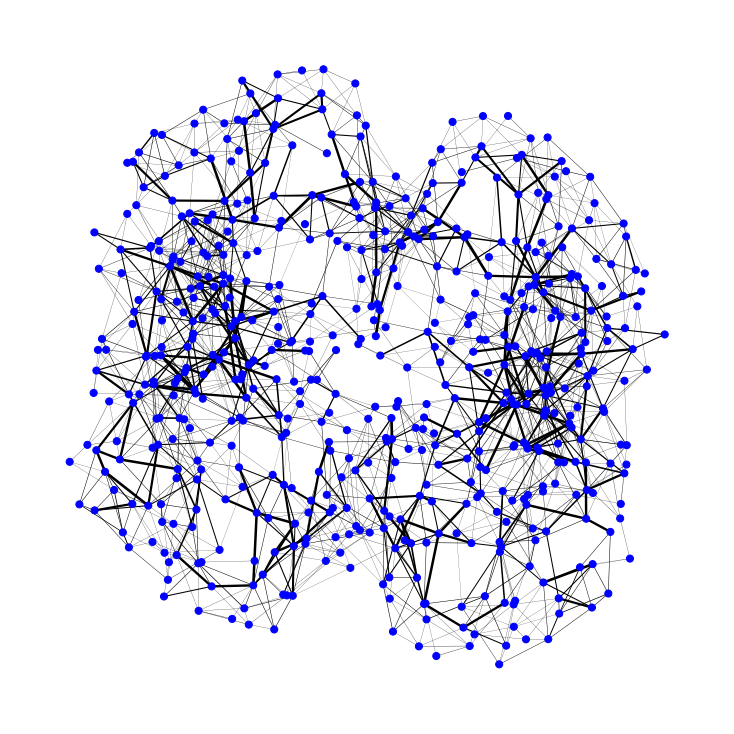

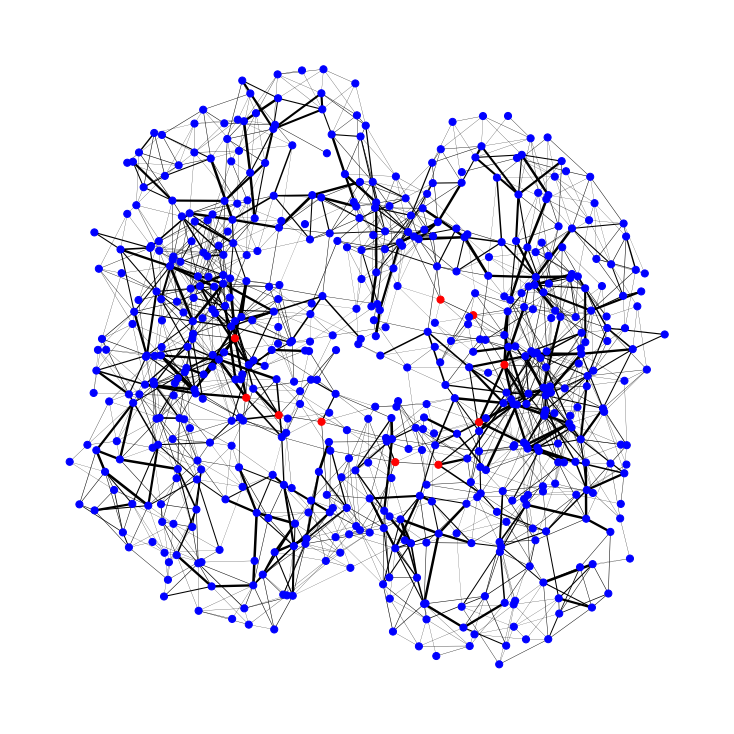

In [15]:
main()